In [213]:
import pandas as pd
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline

In [287]:
df_train_features =  pd.read_csv('/Users/TimothyW/Fun/energy-kaggle/data/train_features.csv', parse_dates = ['timestamp'])


In [288]:
df_train_features = df_train_features.dropna()

In [289]:
df_train_features['24h_avg'] = df_train_features.sort_values(by = ['timestamp'], ascending = True).groupby('building_id')['meter_reading'].rolling(24,24).mean().reset_index(drop = True, level = 0)
df_train_features['24h_std'] = df_train_features.sort_values(by = ['timestamp'], ascending = True).groupby('building_id')['meter_reading'].rolling(24,24).std().reset_index(drop = True, level = 0)

In [290]:
def z_score(row):
    if row['24h_std'] > 0.0:
        return (row['meter_reading'] - row['24h_avg'])/row['24h_std']
    else:
        return 0.0

In [291]:
df_train_features['z_score'] = df_train_features.apply(z_score, axis=1)


In [292]:
df_train_features['z_score'].min()

-4.694855371990722

array([<AxesSubplot:title={'center':'0'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'1'}, ylabel='Frequency'>],
      dtype=object)

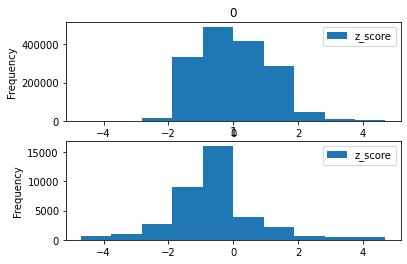

In [293]:
df_train_features.plot.hist(column = 'z_score', by = 'anomaly')

In [294]:
df_train_features = df_train_features.dropna()

In [295]:
features = ['meter_reading','air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','hour','weekday','24h_avg','24h_std', 'z_score']
other = ['building_id','anomaly']

In [274]:
import numpy as np

In [220]:
def downsample_groups(df, frac):
    n_groups = df.building_id.nunique()
    n_keep_ids = int(n_groups* frac)
    keep_ids = np.random.choice(df.building_id.values, size = n_keep_ids)    
    return df[df.building_id.isin(keep_ids)]
    

In [221]:
clf = AdaBoostClassifier(n_estimators = 50)

In [296]:
df_train_features = downsample_groups(df_train_features, frac=0.1)
df_train_features = df_train_features.dropna()

In [297]:
X = df_train_features[features]
y = df_train_features[['anomaly']]

In [281]:
X.shape

(163484, 13)

In [282]:
df_train_features.building_id.nunique()

19

In [226]:
gkf = GroupKFold(3)

In [227]:
score_dict = cross_validate(clf, X, y, cv = gkf, groups=df_train_features[['building_id']], n_jobs = -1, verbose = 9, scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/TimothyW/anaconda3/envs/energy_kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/TimothyW/anaconda3/envs/energy_kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/TimothyW/anaconda3/envs/energy_kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Done   3 

KeyboardInterrupt: 

In [ ]:
score_dict

{'fit_time': array([162.4961369 , 160.38459611, 174.01379824]),
 'score_time': array([0.25645113, 0.24240899, 0.28263569]),
 'test_score': array([0.78591759, 0.7284376 , 0.74011646])}

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
import numpy as np

In [ ]:
class MyRandomUnderSampler:
    def __init__(self):        
        print("initialised under sampler")

    def fit(self, X, y = None):
        X_undersampled, y_undersampled = resample(X[y == 0], y[y == 0],
                replace=True,
                n_samples=X[y == 1].shape[0],
                random_state=123)
        
        self.X_balanced = np.vstack((X[y == 1], X_undersampled))
        self.y_balanced = np.hstack((y[y==1], y_undersampled))
        return self
        

    def transform(self,X,y = None):
        if y:
            return self.X_balanced, self.y_balanced
        else:
            return X
        



In [ ]:
t_x = np.array([[0,1,2,3,4,5],
[6,7,8,9,10,11],
[6,7,8,9,10,12],
[6,7,8,9,10,13]])
t_y = np.array([1,0,0,0])


In [ ]:
t_x.shape
t_y.shape

(4,)

In [ ]:
r = RandomUnderSampler()
r.fit(t_x,t_y)

RandomUnderSampler()

In [ ]:
from sklearn.utils import resample

In [ ]:
X_undersampled, y_undersampled = resample(t_x[t_y == 0], t_y[t_y == 0],
                replace=True,
                n_samples=t_x[t_y == 1].shape[0],
                random_state=123)

In [ ]:
X_undersampled, y_undersampled

(array([[ 6,  7,  8,  9, 10, 13]]), array([0]))

In [ ]:
X_balanced = np.vstack((t_x[t_y == 1], X_undersampled))

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
p = Pipeline([('downsample', SMOTE()), ('adaboost', clf)])

In [ ]:
import dill as pickle

In [ ]:
class MySmote:
    def __init__(self):
        print('initialising smote')    
        self.sm = SMOTE()

    def fit(self, X,y = None):
        print(" called fit ")
        print( "sone some stuff ")
        self.X_sampled, self.y_sampled = self.sm.fit_resample(X,y)            
        return self

    def transform(self,X, y = None):
        print(" calling transform ")
        if y:
            return self.X_sampled, self.y_sampled
        else:
            return self.X_sampled
        
        
    

In [276]:
p2 = Pipeline([('sampling', SMOTE(random_state = 42)), ('adaboost', clf)])

In [283]:
from sklearn.utils import parallel_backend

In [284]:
df_train_features.building_id.nunique()

19

In [299]:
with parallel_backend('threading'):
    score_dict = cross_validate(p2, X, y, cv = gkf, groups=df_train_features[['building_id']], n_jobs= -1, verbose = 9, scoring='roc_auc', return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
/Users/TimothyW/anaconda3/envs/energy_kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/TimothyW/anaconda3/envs/energy_kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................., score=0.779 total time=11.3min
[CV] END ......................................., score=0.779 total time=11.4min
[CV] END ......................................., score=0.726 total time=11.8min
[CV] END ......................................., score=0.884 total time=12.1min
[CV] END ......................................., score=0.726 total time=11.9min
[CV] END ......................................., score=0.884 total time=12.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.2min finished


In [300]:
score_dict

{'fit_time': array([729.43751574, 684.71486998, 713.97274995]),
 'score_time': array([0.555758  , 0.66891193, 0.66397405]),
 'estimator': [Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                  ('adaboost', AdaBoostClassifier())]),
  Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                  ('adaboost', AdaBoostClassifier())]),
  Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                  ('adaboost', AdaBoostClassifier())])],
 'test_score': array([0.8840982 , 0.77937752, 0.72619901])}

In [303]:
clf_sub = score_dict['estimator'][0]

In [313]:
df_test_sub = pd.read_csv('/Users/TimothyW/Fun/energy-kaggle/data/test_features.csv')
df_test_sub['24h_avg'] = df_test_sub.sort_values(by = ['timestamp'], ascending = True).groupby('building_id')['meter_reading'].rolling(24,24).mean().reset_index(drop = True, level = 0)
df_test_sub['24h_std'] = df_test_sub.sort_values(by = ['timestamp'], ascending = True).groupby('building_id')['meter_reading'].rolling(24,24).std().reset_index(drop = True, level = 0)
df_test_sub['z_score'] = df_test_sub.apply(z_score, axis = 1)

In [314]:
df_test_sub = df_test_sub.fillna(0)

In [317]:
def create_submission(clf, test_set_features):
    X = test_set_features[features]
    preds = clf.predict(X)
    df_submit = test_set_features[['row_id']]
    df_submit['anomaly'] = preds
    return df_submit

In [319]:
df_submit = create_submission(clf_sub, df_test_sub)

/var/folders/v3/nvp5qny9761b98yy3p9n041h0000gq/T/ipykernel_94398/2169700057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submit['anomaly'] = preds


In [323]:
df_submit.to_csv('submission_2.csv', index=False)